# Preprocessing and Analysis

### BUSI 722: Data-Driven Finance II
### Kerry Back, Rice University

## Outline 

1. Build dataset of features, returns, and targets as before
2. Add industry features
3. Preprocessing: standardize features relative to other stocks at the same date
4. Train, predict, and form portfolios in loop as before
5. Interpret model 
  - Feature importances 
  - Shapley values
  - Features of best and worst portfolios
6. Evaluate portfolio returns: mean-variance frontiers 
7. Train and save

## 

- Build dataset of features, returns, and targets as before
- Add preprocessing of features
  - Features standardized relative to other stocks at the same date
  - Add interactions of features
- Interpret model
  - Feature importances
  - Shapley values
  - Features of best and worst portfolios
- Evaluate portfolio returns 
  - 


## 1. Create dataset as before

In [19]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

In [20]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver = 'SQL+Server'
string = f"mssql+pyodbc://{username}:{password}@{server}/{database}" 
try: 
    conn = create_engine(string + "?driver='SQL+Server'").connect()
except:
    try:
        conn = create_engine(string + "?driver='ODBC+Driver+18+for+SQL+Server'").connect()
    except:
        import pymssql
        string = f"mssql+pymssql://{username}:{password}@{server}/{database}"   
        conn = create_engine(string).connect() 

In [21]:
sep_weekly = pd.read_sql(
    """ 
    select date, ticker, closeadj, closeunadj, volume, lastupdated from sep_weekly 
    where date >= '2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
sep_weekly = sep_weekly.groupby(["ticker", "date"]).last()
sep_weekly = sep_weekly.drop(columns=["lastupdated"])

ret = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change()
ret.name = "ret"

price = sep_weekly.closeunadj
price.name = "price"

volume = sep_weekly.volume 
volume.name = "volume"

In [22]:
ret_annual = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(52)
ret_monthly = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(4)
mom = (1 + ret_annual) / (1 + ret_monthly) - 1
mom.name = "mom"

In [23]:
weekly = pd.read_sql(
    """ 
    select date, ticker, pb, marketcap, lastupdated from weekly 
    where date>='2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
weekly = weekly.groupby(["ticker", "date"]).last()
weekly = weekly.drop(columns=["lastupdated"])

pb = weekly.pb
pb.name = "pb" 
marketcap = weekly.marketcap 
marketcap.name = "marketcap"

In [24]:
sf1 = pd.read_sql(
    """ 
    select datekey as date, ticker, assets, netinc, equity, lastupdated from sf1
    where datekey>='2010-01-01' and dimension='ARY' and assets>0 and equity>0
    order by ticker, datekey, lastupdated    
    """,
    conn,
)
sf1 = sf1.groupby(["ticker", "date"]).last()
sf1 = sf1.drop(columns=["lastupdated"])

# change dates to Fridays
from datetime import timedelta 
sf1 = sf1.reset_index()
sf1.date =sf1.date.map(
    lambda x: x + timedelta(4 - x.weekday())
)
sf1 = sf1.set_index(["ticker", "date"])
sf1 = sf1[~sf1.index.duplicated()]

assets = sf1.assets
assets.name = "assets" 
netinc = sf1.netinc 
netinc.name = "netinc" 
equity = sf1.equity
equity.name = "equity"

equity = equity.groupby("ticker", group_keys=False).shift() 
roe = netinc / equity 
roe.name = "roe"

assetgr = assets.groupby("ticker", group_keys=False).pct_change()
assetgr.name = "assetgr"

In [25]:
df = pd.concat(
    (
        ret, 
        mom, 
        volume,
        price, 
        pb, 
        marketcap, 
        roe, 
        assetgr
        ), 
        axis=1
    )
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df["roe"] = df.groupby("ticker", group_keys=False).roe.ffill()
df["assetgr"] = df.groupby("ticker", group_keys=False).assetgr.ffill()
df = df[df.price >= 5]
df = df.dropna()

df = df.reset_index()
df.date = df.date.astype(str)
df = df[df.date >= "2012-01-01"]

df["target1"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: x - x.median()
)
df["target2"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100*x.rank(pct=True)
)

features = [
    "mom",
    "volume",
    "pb",
    "marketcap",
    "roe",
    "assetgr" 
]

## 2.  Add industry features

- Deviations from industry medians: is a stock's ROE high relative to its industry, etc. 
- Database includes "famaindustry" which is a classification into 48 industries (including other=almost nothing)

In [27]:
industries = pd.read_sql(
    """ 
    select ticker, famaindustry as industry from tickers   
    """,
    conn,
)
df = df.merge(industries, on="ticker", how="left")
df = df.dropna()

In [28]:
for x in features:
    df[f"{x}_industry"] = df.groupby(
        ["date", "industry"], 
        group_keys=False
    )[x].apply(
        lambda x: x - x.median()
    )

features += [f"{x}_industry" for x in features]

## 3. Preprocessing: standardize at each date

We are predicting relative performance.  It makes sense to use relative features: how does a stock compare to other stocks at the same date?  There are multiple options:

- standard scaler (subtract mean and divide by std dev)
- quantile transformer (map to normal or uniform distribution)
- rank with pct=True (quantile transformer to uniform distribution)

Here we will rank.

In [29]:
for f in features:
    df[f] = df.groupby("date", group_keys=False)[f].apply(
        lambda x: x.rank(pct=True)
    )

## 4. Train, predict and form portfolios as before

- If we set train_freq to a large number, the loop will only train once.  Use trained model to predict at all subsequent dates.  Do this only for demonstration.
- Should validate but will use max_depth=4 and max_features=6 in the random forest.

In [30]:
train_years = 4 # num years of past data to use for training
train_freq = 100  # num years between training 
target = "target2"
model = RandomForestRegressor(max_depth=4, max_features=6)

years = range(2012+train_years, 2024, train_freq)
df2 = None 
for i, year in enumerate(years):
    print(year)
    start_train = f"{year-train_years}-01-01"
    start_predict = f"{year}-01-01"
    if year == years[-1]:
        stop_predict = "2100-01-01"
    else:
        stop_predict = f"{years[i+1]}-01-01"
    past = df[(df.date >= start_train) & (df.date < start_predict)]
    future = df[(df.date>=start_predict) & (df.date<stop_predict)].copy()
    model.fit(X=past[features], y=past[target])
    future["predict"] = model.predict(X=future[features])
    df2 = pd.concat((df2, future))

df2.head()

2016


,ticker,date,ret,mom,volume,price,pb,marketcap,roe,assetgr,target1,target2,industry,mom_industry,volume_industry,pb_industry,marketcap_industry,roe_industry,assetgr_industry,predict
208,A,2016-01-01,-0.023424,0.527660,0.861866,41.78,0.712111,0.895254,0.404910,0.011129,0.002636,53.836108,Measuring and Control Equipment,0.629133,0.877250,0.709984,0.901473,0.382324,0.016694,50.783986
209,A,2016-01-08,-0.067579,0.563833,0.876928,40.69,0.713817,0.894650,0.403348,0.010502,-0.019937,36.923077,Measuring and Control Equipment,0.660322,0.890712,0.697735,0.900230,0.383328,0.016410,50.790487
210,A,2016-01-15,-0.019511,0.545697,0.859907,37.94,0.710474,0.892595,0.397265,0.011007,0.015478,64.105123,Measuring and Control Equipment,0.612742,0.876251,0.697298,0.900600,0.382255,0.016344,50.783986
211,A,2016-01-22,0.011010,0.621860,0.816361,37.20,0.720129,0.894094,0.389341,0.010183,0.006092,57.433119,Measuring and Control Equipment,0.684657,0.844196,0.709437,0.898506,0.380177,0.014257,50.790487
212,A,2016-01-29,0.002127,0.614968,0.835083,37.61,0.718591,0.895361,0.393159,0.010498,-0.024228,29.054054,Measuring and Control Equipment,0.681341,0.856079,0.722486,0.900779,0.381646,0.015577,50.790487


In [31]:
num_stocks = 50

grouped = df2.groupby("date", group_keys=False).predict
starting_from_best = grouped.rank(ascending=False, method="first")
best = df2[starting_from_best <= num_stocks]
best_rets = best.groupby("date", group_keys=True).ret.mean()
best_rets.index = pd.to_datetime(best_rets.index)

starting_from_worst = grouped.rank(ascending=True, method="first")
worst = df2[starting_from_worst <= num_stocks]
worst_rets = worst.groupby("date", group_keys=True).ret.mean()
worst_rets.index = pd.to_datetime(worst_rets.index)

all_rets = df2.groupby("date", group_keys=True).ret.mean()
all_rets.index = pd.to_datetime(all_rets.index)

## 4. Interpret

### Find feature importances for last trained model

In [32]:
importances = pd.Series(
    model.feature_importances_, 
    index=features
)
importances = importances.sort_values(ascending=False)
importances.round(2)

mom                   0.26
volume_industry       0.26
volume                0.18
roe                   0.06
mom_industry          0.06
roe_industry          0.06
pb                    0.03
marketcap             0.03
pb_industry           0.02
marketcap_industry    0.02
assetgr_industry      0.01
assetgr               0.01
dtype: float64

### Shapley values 

- Shapley values are a way of calculating the contribution each feature makes to predictions.
- Values are calculated for each observation (each stock/date).
- Can use any part of the data, but look here at last prediction date. 
- First look at the distribution of predictions, then at the contributions.

In [33]:
last_date = df2.date.max()
df3 = df2[df2.date==last_date]
df3.predict.describe().round(3)

count    2962.000
mean       50.016
std         1.095
min        43.057
25%        49.451
50%        50.493
75%        50.846
max        51.508
Name: predict, dtype: float64

In [34]:
import shap 

explainer = shap.Explainer(model) 
shap_values = explainer(df3[features])

### Mean absolute Shapley values

- Shapley values are positive or negative, depending on whether a feature is positively or negatively related to the prediction.
- Here we average the absolute Shapley values across observations to see which features are on average most important (like feature_importances).

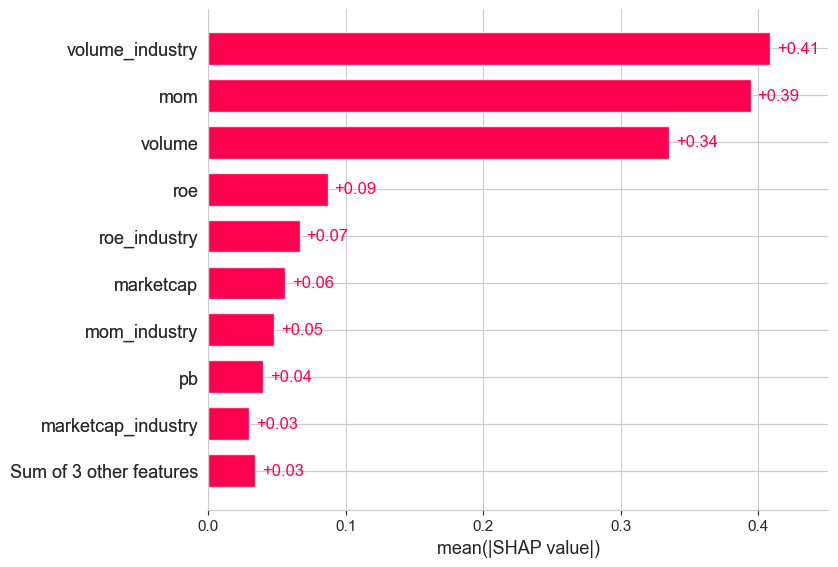

In [35]:
shap.plots.bar(shap_values)

### Look at Shapley values across observations

- Look at Shapley values one feature at a time
- Plot the Shapley value across observations as a function of the feature
- Shaded plot at bottom is histogram of the feature

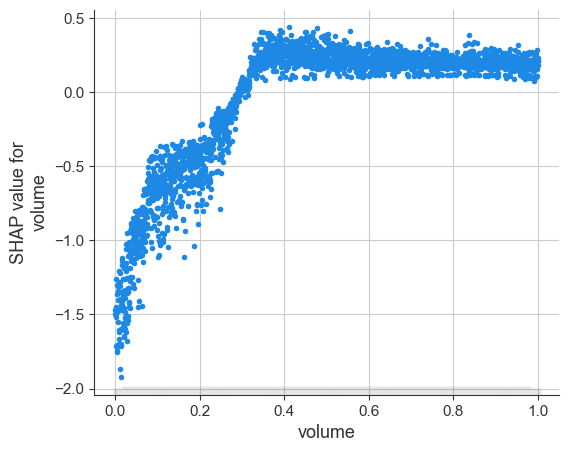

In [36]:
feature = "volume" 
shap.plots.scatter(shap_values[:, feature])

### Extract best, worst, and all stocks in last portfolios

In [37]:
best_last = best[best.date==last_date].copy()
worst_last = worst[worst.date==last_date].copy()
all_last = df2[df2.date==last_date].copy()

best_last["group"] = "best" 
worst_last["group"] = "worst" 
all_last["group"] = "all"

last = pd.concat((best_last, worst_last, all_last))

### Compare features of best, worst, and all portfolios

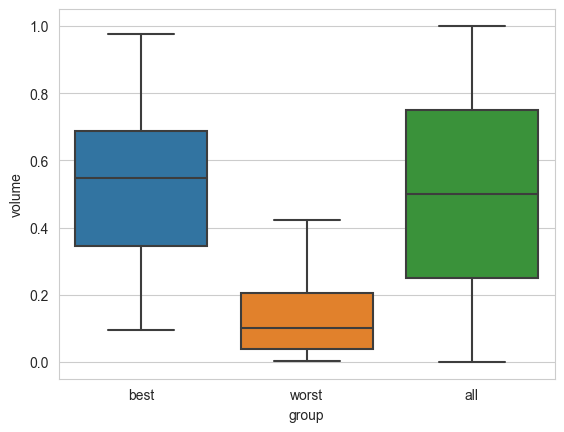

In [38]:
feature = "volume"
sns.boxplot(last, x="group", y=feature)
plt.show()

## 6. Evaluate

### Add SPY returns

In [53]:
import yfinance as yf

spy = yf.download("SPY", start=2017)["Adj Close"]
spy = pd.DataFrame(spy)
spy["date"] = spy.index.map(
    lambda x: x + timedelta(4 - x.weekday())
)
spy = spy.groupby(["date"])["Adj Close"].last()
spy = spy.pct_change()

rets = pd.concat((spy, best_rets, worst_rets), axis=1).dropna()
rets.columns = ["spy", "best", "worst"]


[*********************100%%**********************]  1 of 1 completed


### Return statistics

In [54]:
means = 52 * rets.mean()
stdevs = np.sqrt(52) * rets.std()
rf = 0.05
sharpes = (means - rf) / stdevs
stats = pd.concat((means, stdevs, sharpes), axis=1)
stats.columns = ["mean", "std", "sharpe"]
stats.round(2)

,mean,std,sharpe
spy,0.14,0.18,0.52
best,0.35,0.28,1.04
worst,-0.25,0.32,-0.93


In [55]:
rets.corr().round(2)

,spy,best,worst
spy,1.00,0.40,0.36
best,0.40,1.00,0.59
worst,0.36,0.59,1.00


### Plot performance

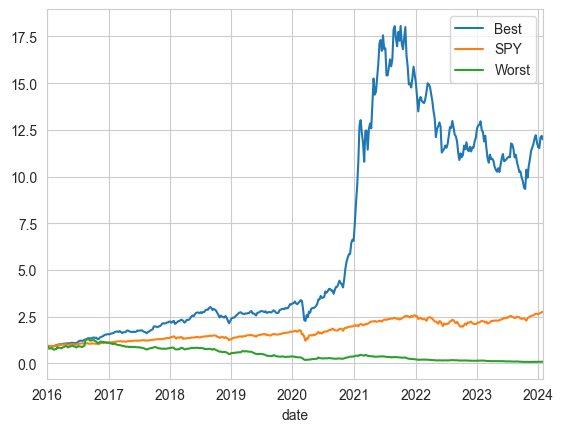

In [56]:
logy = False 

(1+rets.best).cumprod().plot(label="Best", logy=logy)
(1+rets.spy).cumprod().plot(label="SPY", logy=logy)
(1+rets.worst).cumprod().plot(label="Worst", logy=logy)
plt.legend()
plt.show()

### Find frontier of SPY, best, and worst

In [57]:
from cvxopt import matrix
from cvxopt.solvers import qp

cov = rets.cov()
means = rets.mean() 

P = cov
A = np.array(
    [
        means.to_numpy(),
        [1., 1., 1.]
    ]
)
P = matrix(P.to_numpy())
q = matrix(np.zeros((3, 1)))
A = matrix(A)

mns = [] 
vars = [] 
ports = []
for targ in np.linspace(0, 0.5/52, 100):
    b = matrix(
        np.array([targ, 1]).reshape(2, 1)
    )
    sol = qp(
        P=P,
        q=q,
        A=A,
        b=b
    )
    w = pd.Series(sol["x"], index=rets.columns)
    mns.append(w @ means)
    vars.append(w @ cov @ w)
    ports.append(w)

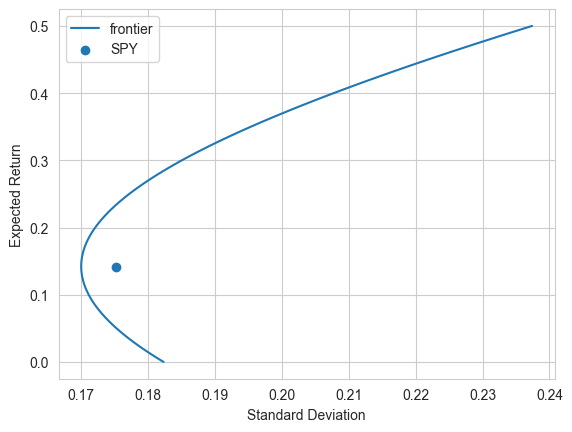

In [58]:
mns = 52 * np.array(mns)
sds = np.sqrt(52*np.array(vars))

plt.plot(sds, mns, label="frontier")
plt.scatter(x=[np.sqrt(52)*rets.spy.std()], y=[52*rets.spy.mean()], label="SPY")
plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")
plt.legend()
plt.show()

### Find best portfolio with same risk as SPY

In [59]:
stdev = np.max(
    [
        s for s, m in zip(sds, mns) 
        if s <= np.sqrt(52)*rets.spy.std()
        and m >= 52*rets.spy.mean()
    ]
)
indx = np.where(sds==stdev)[0].item()
mean = mns[indx]
port = ports[indx]
print(port.round(2))
print(f"portfolio expected return is {mean:.1%}")

spy      0.83
best     0.26
worst   -0.10
dtype: float64
portfolio expected return is 23.2%


### Long-only portfolios of SPY and best

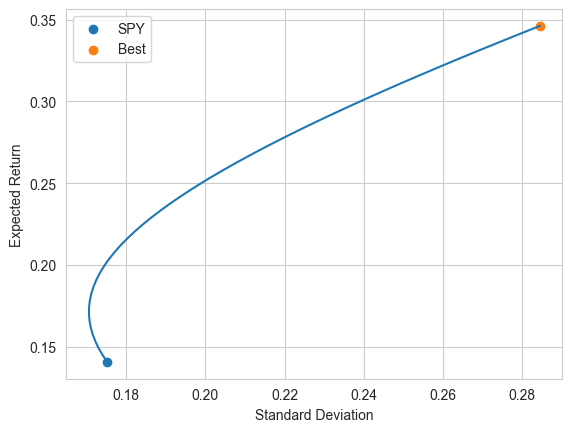

In [60]:
means = rets[["spy", "best"]].mean()
cov = rets[["spy", "best"]].cov()
ports = [np.array([w, 1-w]) for w in np.linspace(0, 1, 50)]
mns = [52 * means @ w for w in ports]
sds = [np.sqrt(52 * w @ cov @ w) for w in ports]

plt.plot(sds, mns, label=None)
plt.scatter(x=[np.sqrt(52)*rets.spy.std()], y=[52*rets.spy.mean()], label="SPY")
plt.scatter(x=[np.sqrt(52)*rets.best.std()], y=[52*rets.best.mean()], label="Best")
plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")
plt.legend()
plt.show()

### 140/40 portfolio

In [61]:
rets["140/40"] = rets.spy + 0.4*rets.best - 0.4*rets.worst

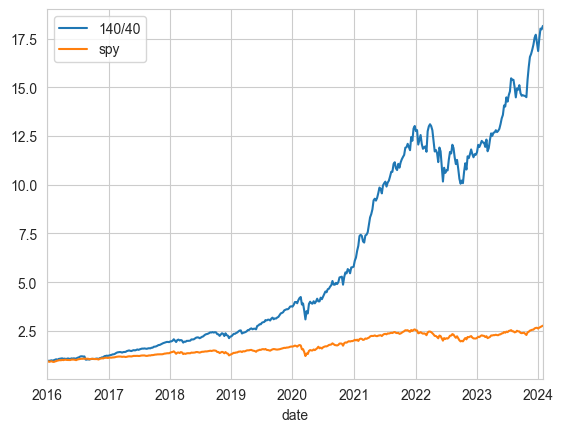

In [62]:
(1+rets[["140/40", "spy"]]).cumprod().plot()
plt.show()

## 7. Train and save

- Train on the most recent train_years of data 
- Save with joblib

In [63]:
from joblib import dump 

dates = df.date.unique()
dates.sort()
date = dates[-52*train_years]
df3 = df[df.date>=date]
model.fit(df3[features], df3["target2"])
dump(model, "mymodel.joblib")

['mymodel.joblib']